In [ ]:
#Load training and testing images

!unzip "/home/no_mask.zip" -d "/home"
!unzip "/home/mask.zip" -d "/home"

!rm -r "/home/my_face_pretrained"
!mkdir "/home/my_face_pretrained"

!rm -r "/home/my_face"
!mkdir "/home/my_face"

Archive:  /home/no_mask.zip
  inflating: /home/no_mask/0.jpg     
  inflating: /home/no_mask/1.jpg     
  inflating: /home/no_mask/10.jpg    
  inflating: /home/no_mask/2.jpg     
  inflating: /home/no_mask/3.jpg     
  inflating: /home/no_mask/4.jpg     
  inflating: /home/no_mask/5.jpg     
  inflating: /home/no_mask/6.jpg     
  inflating: /home/no_mask/7.jpg     
  inflating: /home/no_mask/8.jpg     
  inflating: /home/no_mask/9.jpg     
Archive:  /home/mask.zip
  inflating: /home/mask/0.jpg        
  inflating: /home/mask/1.jpg        
  inflating: /home/mask/10.jpg       
  inflating: /home/mask/2.jpg        
  inflating: /home/mask/3.jpg        
  inflating: /home/mask/4.jpg        
  inflating: /home/mask/5.jpg        
  inflating: /home/mask/6.jpg        
  inflating: /home/mask/7.jpg        
  inflating: /home/mask/8.jpg        
  inflating: /home/mask/9.jpg        


**Color Segmentation**

In order to train the model to identify which part of the image to reconstruct, 
we apply color segmentation to remove the mask pixels from the images. The model will learn to "fill in" pixels with the value 0.


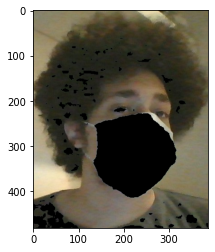

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread("/home/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask2 = cv2.inRange(hsv, (0,0,0), (70, 255, 255))

target = cv2.bitwise_and(img,img, mask=mask2)


plt.imshow(img-target)

In [ ]:
#import the deep learning libraries and defining the parameters of our model

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,  LeakyReLU, Conv2DTranspose
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, MaxPool2D, Add
from keras.layers import UpSampling2D, Conv2D, Reshape
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.losses import cosine_similarity
from keras.regularizers import l2

latent_dim = 100
img_shape = (128, 128, 3)

Using TensorFlow backend.


**Model creation function**

In [ ]:
def denoiser():
    input_img = Input(shape=img_shape)  # adapt this if using `channels_first` image data format
    #128
    skip3 = Conv2D(128, (5, 5), padding='same', strides=2, kernel_initializer="he_normal")(input_img)
    x = BatchNormalization()(skip3)
    x = LeakyReLU(alpha=0.0)(x)
    #64
    skip1 = Conv2D(256, (3, 3), padding='same', strides=2, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(skip1)
    x = LeakyReLU(alpha=0.0)(x)
    #32
    skip2 = Conv2D(512, (3, 3), padding='same', strides=2, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(skip2)
    x = LeakyReLU(alpha=0.0)(x)
    #16
    x = Conv2D(1024, (3, 3), padding='same', strides=2, kernel_initializer="he_normal")(x)
    encoded = LeakyReLU(alpha=0.0)(x)
    #8
    #8
    x = Conv2DTranspose(512, (3, 3), strides = 2, padding='same', kernel_initializer="he_normal")(encoded)
    x = Add()([x, skip2])
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.0)(x)
    #4
    x = Conv2DTranspose(256, (3, 3), strides = 2, padding='same', kernel_initializer="he_normal")(x)
    x = Add()([x, skip1])
    x = LeakyReLU(alpha=0.0)(x)
    #8
    x = Conv2DTranspose(128, (3, 3), strides = 2, padding='same', kernel_initializer="he_normal")(x)
    x = Add()([x, skip3])
    x = LeakyReLU(alpha=0.0)(x)
    #16
    x = Conv2DTranspose(64, (3, 3), strides = 2, padding='same', kernel_initializer="he_normal")(x)
    x = LeakyReLU(alpha=0.0)(x)
    #32
    decoded = Conv2D(3, (1, 1), activation='sigmoid', padding='same', kernel_initializer="he_normal")(x)
    model = Model(input_img, decoded)

    corrupt = Input(shape=img_shape)
    img = model(corrupt)

    denoiser = Model(corrupt, img)
    return denoiser

Logcosh loss function is used for training, a logcosh function is unique in that for a small loss value it is similar to Mean-Squared Error but as the loss increases it becomes similar to Mean-Average Error. Logcosh combines the advantages of MAE and MSE by training the model to be more robust to outliers while also not punishing the model

In [ ]:
denoiser_model = denoiser()
denoiser_model.compile(loss="logcosh", optimizer="adam")
denoiser_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 128, 128, 3)       12478339  
Total params: 12,478,339
Trainable params: 12,475,523
Non-trainable params: 2,816
_________________________________________________________________


In [ ]:
from keras.applications import InceptionResNetV2, Xception
def denoiser_InceptionResNetV2():
    input_img = Input(shape=img_shape)  # adapt this if using `channels_first` image data format
    pretrained_model = Xception( include_top=False,
                                          weights="imagenet",
                                          input_tensor=None,
                                          input_shape=img_shape,
                                          pooling=None,
                                          classes=1000)
    
    x = pretrained_model(input_img)
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.0)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.0)(x)
    encoded = Reshape((1,1,512))(x)

    #1
    x = Conv2DTranspose(512, (3, 3), strides = 2, padding='same', kernel_initializer="he_normal")(encoded)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.0)(x)
    #2
    x = Conv2DTranspose(256, (3, 3), strides = 2, padding='same', kernel_initializer="he_normal")(x)
    x = LeakyReLU(alpha=0.0)(x)
    #4
    x = Conv2DTranspose(256, (3, 3), strides = 2, padding='same', kernel_initializer="he_normal")(x)
    x = LeakyReLU(alpha=0.0)(x)
    #8
    x = Conv2DTranspose(128, (3, 3), strides = 2, padding='same', kernel_initializer="he_normal")(x)
    x = LeakyReLU(alpha=0.0)(x)
    #16
    x = Conv2DTranspose(128, (3, 3), strides = 2, padding='same', kernel_initializer="he_normal")(x)
    x = LeakyReLU(alpha=0.0)(x)
    #32
    x = Conv2DTranspose(64, (3, 3), strides = 2, padding='same', kernel_initializer="he_normal")(x)
    x = LeakyReLU(alpha=0.0)(x)
    #64
    x = Conv2DTranspose(32, (3, 3), strides = 2, padding='same', kernel_initializer="he_normal")(x)
    x = LeakyReLU(alpha=0.0)(x)
    #128
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', kernel_initializer="he_normal")(x)
    model = Model(input_img, decoded)

    corrupt = Input(shape=img_shape)
    img = model(corrupt)

    denoiser = Model(corrupt, img)
    return denoiser


Cosine similarity is normal used in the context of natural language processing as it can evaluate the similarity of two sentences. In the context of demasking, cosine similarity forces the model to learn how to reconstruct facial features under the mask better that Mean-squared error loss or Binary Cross entropy. more information on cosine similarity could be found here https://en.wikipedia.org/wiki/Cosine_similarity

In [ ]:
pretrained_autoencoder = denoiser_InceptionResNetV2()
pretrained_autoencoder.compile(loss="cosine_similarity", optimizer="adam")
pretrained_autoencoder.summary()

83689472/83683744 [==============================] - 4s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 128, 128, 3)       59609323  
Total params: 59,609,323
Trainable params: 59,553,771
Non-trainable params: 55,552
_________________________________________________________________


In [ ]:
#loading in images

import numpy as np
import os, cv2

def load_images(path):
        images = sorted(os.listdir(path));
        X = []
        for image in images:
            img = cv2.imread(path+"/"+image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            X.append(img.copy())

        X = np.array(X)
        
        return X

x_mask_train = load_images("/home/mask")
x_no_mask_train = load_images("/home/no_mask")

**Training the model**

In [ ]:
import matplotlib.pyplot as plt
import imutils

os.chdir("..")

batch_size = 32
for epoch in range(0,50000):

    mask_batch = []
    no_mask_batch = []

    for i in range(batch_size):
        random_img_id = np.random.randint(low=0, high=x_mask_train.shape[0], size=1)[0]

        mask_img = x_mask_train[random_img_id,:,:,:]
        no_mask_img = x_no_mask_train[random_img_id,:,:,:]
        

        stretch_prob = np.random.rand(1)[0]
        if stretch_prob > 0.2:
            stretch_kind_prob = np.random.rand(1)[0]
            if stretch_kind_prob < 0.25:
                random_stretch = np.random.randint(low=128, high=150, size=1)[0]
                #stretcht down
                pts1 = np.float32([[0,0],[0,128],[128,0],[128,128]])
                pts2 = np.float32([[0,0],[0,random_stretch],[128,0],[128,random_stretch]])

            elif (stretch_kind_prob > 0.25) and (stretch_kind_prob<0.5):
                random_stretch = np.random.randint(low=128, high=150, size=1)[0]
                #stretcht right
                pts1 = np.float32([[0,0],[0,128],[128,0],[128,128]])
                pts2 = np.float32([[0,0],[0,128],[random_stretch,0],[random_stretch,128]])

            elif (stretch_kind_prob > 0.5) and (stretch_kind_prob<0.75):
                random_stretch = np.random.randint(low=128, high=150, size=1)[0]
                #stretch right down
                pts1 = np.float32([[0,0],[0,128],[128,0],[128,128]])
                pts2 = np.float32([[0,0],[0,128],[random_stretch,0],[random_stretch,random_stretch]])

            elif (stretch_kind_prob > 0.75) and (stretch_kind_prob<1.0):
                random_stretch = np.random.randint(low=128, high=150, size=1)[0]
                #stretch right up
                pts1 = np.float32([[0,0],[0,128],[128,0],[128,128]])
                pts2 = np.float32([[0,0],[0,random_stretch],[random_stretch,0],[random_stretch,128]])

            M = cv2.getPerspectiveTransform(pts1,pts2)
            mask_img = cv2.warpPerspective(mask_img,M,(128,128))
            no_mask_img = cv2.warpPerspective(no_mask_img,M,(128,128))
            
            flip_prob = np.random.rand(1)[0]
            if flip_prob > 0.3:
                mask_img = cv2.flip(mask_img, 1)
                no_mask_img = cv2.flip(no_mask_img, 1)
            
        #remove mask
        hsv = cv2.cvtColor(mask_img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, (0,0,0), (70, 255, 255))
        target = cv2.bitwise_and(mask_img,mask_img, mask=mask)
        mask_img = mask_img-target


        mask_img = mask_img.astype('float32')/255.
        no_mask_img = no_mask_img.astype('float32')/255.

        mask_batch.append(mask_img.copy())
        no_mask_batch.append(no_mask_img.copy())

    mask_batch = np.array(mask_batch)
    no_mask_batch = np.array(no_mask_batch)

    denoiser_loss = denoiser_model.train_on_batch(mask_batch, no_mask_batch)

    print (f"\rEpoch: {epoch} [pretrained Denoiser loss: {denoiser_loss}]", end="")


    if epoch % 100 == 0:
        r, c = 4, 4

        fig, axs = plt.subplots(r, c)
        for i in range(c):
            mask_img_orig = x_mask_train[i,:,:,:]
            hsv = cv2.cvtColor(mask_img_orig, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv, (0,0,0), (70, 255, 255))
            target = cv2.bitwise_and(mask_img_orig,mask_img_orig, mask=mask)
            mask_img_orig = mask_img_orig-target

            gen_imgs = denoiser_model.predict(np.array([mask_img_orig/255.]))


            axs[0,i].imshow(x_mask_train[i,:,:,:])
            axs[0,i].axis('off')
            axs[1,i].imshow(mask_img_orig)
            axs[1,i].axis('off') 
            axs[2,i].imshow(x_no_mask_train[i,:,:,:])
            axs[2,i].axis('off')
            axs[3,i].imshow(gen_imgs[0,:,:,:])
            axs[3,i].axis('off')

        fig.savefig("./home/my_face/%d.png" % epoch)
        plt.close()

Epoch: 50000 [pretrained Denoiser loss: 4.597201768774539e-05]

**Testing on unseen images**

(-0.5, 127.5, 127.5, -0.5)

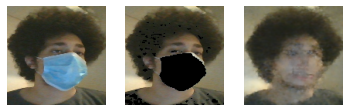

In [ ]:
orig_img = cv2.imread("/home/1.jpg")
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
orig_img = cv2.resize(orig_img, (128, 128))

img = orig_img
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, (0,0,0), (70, 255, 255))
target = cv2.bitwise_and(img,img, mask=mask)
img = img-target

img = img.astype('float32') /255.

train_img = img
#train_img = x_mask_train[5,:,:,:]/255.

predicted1 = denoiser_model.predict(np.array([train_img]))
predicted1 = predicted1[0,:,:,:]


import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 3)

axs[0].imshow(cv2.resize(orig_img, (128, 128)))
axs[0].axis('off')
axs[1].imshow(train_img)
axs[1].axis('off')
axs[2].imshow(predicted1)
axs[2].axis('off')

#fig.savefig("./home/image_0_results.png")


**Testing augmentation techniques here, this section could be removed**

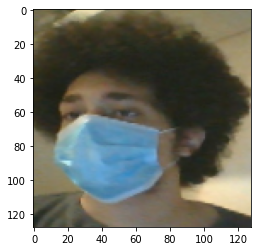

In [ ]:
img = cv2.imread("/home/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))

#stretcht down
pts1 = np.float32([[0,0],[0,128],[128,0],[128,128]])
pts2 = np.float32([[0,0],[0,200],[128,0],[128,200]])

#stretcht right
pts1 = np.float32([[0,0],[0,128],[128,0],[128,128]])
pts2 = np.float32([[0,0],[0,128],[200,0],[200,128]])

#stretch right down
pts1 = np.float32([[0,0],[0,128],[128,0],[128,128]])
pts2 = np.float32([[0,0],[0,128],[180,0],[180,180]])

#stretch right up
pts1 = np.float32([[32,32],[32,128],[64,32],[128,128]])
pts2 = np.float32([[32,32],[32,140],[140,32],[140,128]])

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(128,128))

dst = cv2.flip(dst, 1)
plt.imshow(dst)